<div>
<h1>Model</h1>
</div>

In [1]:
from sys import path
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [2]:
model_dir = 'sample_code_submission/'                        # Change the model to a better one once you have one!
#model_dir = '../FILES/pretty_good_sample_code_submission/'
result_dir = 'sample_result_submission/' 
problem_dir = 'ingestion_program/'  
score_dir = 'scoring_program/'
path.append(model_dir); path.append(problem_dir); path.append(score_dir); 
%matplotlib inline
# Uncomment the next lines to auto-reload libraries (this causes some problem with pickles in Python 3)
%load_ext autoreload
%autoreload 2
sns.set()

In [3]:
from data_io import read_as_df
data_dir = './input_data'        # Change this to the directory where you put the input data
#data_dir = './all_data'          # The sample_data directory should contain only a very small subset of the data
data_name = 'xporters'
!ls $data_dir*

'ls' n'est pas reconnu en tant que commande interne
ou externe, un programme ex‚cutable ou un fichier de commandes.


In [4]:
data = read_as_df(data_dir  + '/' + data_name)                # The data are loaded as a Pandas Data Frame

Reading ./input_data/xporters_train from AutoML format
Number of examples = 38563
Number of features = 59


<div>
    <h2>Loading data with DataManager</h2>
    <p>
We reload the data with the AutoML DataManager class because this is more convenient:
   <br>     <span style="color:red"> Keep this, it illustrates how data in AutoML formal are loaded by the ingestion program </span>
</div>

In [5]:
from data_manager import DataManager
D = DataManager(data_name, data_dir, replace_missing=True)
print(D)

Info file found : C:\Users\mazen\Documents\mini projet\starting_kit\input_data\xporters_public.info
DataManager : xporters
info:
	usage = Sample dataset Traffic Volume data
	name = traffic
	task = regression
	target_type = Numerical
	feat_type = Numerical
	metric = r2_metric
	time_budget = 1200
	feat_num = 59
	target_num = 3
	label_num = 3
	train_num = 35
	valid_num = 35
	test_num = 35
	has_categorical = 0
	has_missing = 0
	is_sparse = 0
	format = dense
data:
	X_train = array(38563, 59)
	Y_train = array(38563,)
	X_valid = array(4820, 59)
	Y_valid = array(0,)
	X_test = array(4820, 59)
	Y_test = array(0,)
feat_type:	array(59,)
feat_idx:	array(0,)



<div>
    <h2>Training a predictive model</h2>
    <p>
We provide an example of predictive model (for classification or regression) in the `sample_code_submission/` directory. It is a quite stupid model: it makes constant predictions. Replace it with your own model.
    </div>

In [6]:
from data_io import write
from model import model
# Uncomment the next line to show the code of the model
#??model

<div>
an instance of the model (run the constructor) and attempt to reload a previously saved version from `sample_code_submission/`:
    
</div>

In [7]:
M = model()
trained_model_name = model_dir + data_name
# Uncomment the next line to re-load an already trained model
print(trained_model_name)
#M = M.load(trained_model_name)                  

sample_code_submission/xporters


<div>
    Train the model (unless you reloaded a trained model) and make predictions. 
</div>

In [8]:
X_train = D.data['X_train']
Y_train = D.data['Y_train']

In [9]:

if not(M.is_trained) : M.fit(X_train, Y_train)                     
Y_hat_train = M.predict(D.data['X_train']) # Optional, not really needed to test on taining examples
Y_hat_valid = M.predict(D.data['X_valid'])
Y_hat_test = M.predict(D.data['X_test'])

In [11]:
print(Y_hat_train)

[ 808.67765477 4177.92542158 3416.83991152 ... 5870.46271826 4175.79855341
 5685.98170999]


<div>
    <b> Save the trained model </b> (will be ready to reload next time around) and save the prediction results. IMPORTANT: if you save the trained model, it will be bundled with your sample code submission. Therefore your model will NOT be retrained on the challenge platform. Remove the pickle from the submission if you want the model to be retrained on the platform.
</div>

In [12]:
M.save(trained_model_name)                 
result_name = result_dir + data_name
from data_io import write
write(result_name + '_train.predict', Y_hat_train)
write(result_name + '_valid.predict', Y_hat_valid)
write(result_name + '_test.predict', Y_hat_test)
!ls $result_name*

'ls' n'est pas reconnu en tant que commande interne
ou externe, un programme ex‚cutable ou un fichier de commandes.


<div>
    <h2>Scoring the results</h2>
    <h3>Load the challenge metric</h3>
    <p>
<b>The metric chosen for your challenge</b> is identified in the "metric.txt" file found in the `scoring_function/` directory. The function "get_metric" searches first for a metric having that name in my_metric.py, then in libscores.py, then in sklearn.metric.
    </div>

In [9]:
from libscores import get_metric
metric_name, scoring_function = get_metric()
print('Using scoring metric:', metric_name)
# Uncomment the next line to display the code of the scoring metric
??scoring_function

Using scoring metric: r2_metric


<div>
    <h3> Training performance </h3>
    <p>
The participants normally posess target values (labels) only for training examples (except for the sample data). We compute with the `example` metric the training score, which should be zero for perfect predictions.
        </div>

In [14]:
print('Training score for the', metric_name, 'metric = %5.4f' % scoring_function(Y_train, Y_hat_train))
print('Ideal score for the', metric_name, 'metric = %5.4f' % scoring_function(Y_train, Y_train))

Training score for the r2_metric metric = 0.9828
Ideal score for the r2_metric metric = 1.0000


You can add here other scores and result visualization.

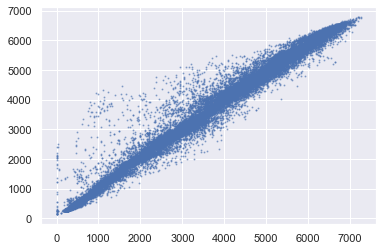

In [15]:
plt.scatter(Y_train, Y_hat_train, alpha ='0.5', s = 1 )
plt.show()

<div>
    <h3>Cross-validation performance</h3>
    <p>
The participants do not have access to the labels Y_valid and Y_test to self-assess their validation and test performances. But training performance is not a good prediction of validation or test performance. Using cross-validation, the training data is split into multiple training/test folds, which allows participants to self-assess their model during development. The average CV result and 95% confidence interval is displayed.
   </div>

In [21]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
scores = cross_val_score(M, X_train, Y_train, cv=5, scoring=make_scorer(scoring_function))
print('\nCV score (95 perc. CI): %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

KeyboardInterrupt: 

<div>
<h1> Step 3: Making a submission </h1> 

<h2> Unit testing </h2> 

It is <b><span style="color:red">important that you test your submission files before submitting them</span></b>. All you have to do to make a submission is modify the file <code>model.py</code> in the <code>sample_code_submission/</code> directory, then run this test to make sure everything works fine. This is the actual program that will be run on the server to test your submission. 
<br>
Keep the sample code simple.
</div>

In [30]:
!source activate python3; python $problem_dir/ingestion.py $data_dir $result_dir $problem_dir $model_dir

'source' n'est pas reconnu en tant que commande interne
ou externe, un programme ex‚cutable ou un fichier de commandes.


<div>
Also test the scoring program:
    </div>

In [31]:
scoring_output_dir = 'scoring_output'
!source activate python3; python $score_dir/score.py $data_dir $result_dir $scoring_output_dir

'source' n'est pas reconnu en tant que commande interne
ou externe, un programme ex‚cutable ou un fichier de commandes.


<div>
    <h1> Preparing the submission </h1>

Zip the contents of `sample_code_submission/` (without the directory), or download the challenge public_data and run the command in the previous cell, after replacing sample_data by public_data.
Then zip the contents of `sample_result_submission/` (without the directory).
<b><span style="color:red">Do NOT zip the data with your submissions</span></b>.

In [32]:
import datetime 
from data_io import zipdir
the_date = datetime.datetime.now().strftime("%y-%m-%d-%H-%M")
sample_code_submission = '../sample_code_submission_' + the_date + '.zip'
sample_result_submission = '../sample_result_submission_' + the_date + '.zip'
zipdir(sample_code_submission, model_dir)
zipdir(sample_result_submission, result_dir)
print("Submit one of these files:\n" + sample_code_submission + "\n" + sample_result_submission)

Submit one of these files:
../sample_code_submission_20-04-01-14-33.zip
../sample_result_submission_20-04-01-14-33.zip


<div>
    <h1> Model (MAZEN et Haithem) </h1>

</div>

<div>
    <h1>I) Cross validation perfermonce  </h1>

</div>

In [25]:
#RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor

#KNeighborsRegressor
from sklearn.neighbors import KNeighborsRegressor

#DecisionTreeRegressor 
from sklearn.tree import DecisionTreeRegressor

#LinearRegression
from sklearn.linear_model import LinearRegression


#ExtraTreesRegressor 
from sklearn.ensemble import ExtraTreesRegressor

#GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor

#BaggingRegressor
from sklearn.ensemble import BaggingRegressor

In [26]:
modelName = [ "KNeighborsRegressor","RandomForestRegressor", "DecisionTreeRegressor",
         "ExtraTreesRegressor","GradientBoostingRegressor","BaggingRegressor"]

modelList = [
    KNeighborsRegressor(),
    RandomForestRegressor(max_depth=20, random_state=0,  n_estimators=100 ),   
    DecisionTreeRegressor(),
    ExtraTreesRegressor(),
    GradientBoostingRegressor(),
    BaggingRegressor()
]

In [29]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
scores_performance=[]
scores_error=[]
for i in range(len(modelList)):
    scores = cross_val_score(modelList[i], X_train, Y_train, cv=5, scoring=make_scorer(scoring_function))
    scores_performance.append(scores.mean())
    scores_error.append(scores.std())
    print('\n'+modelName[i]+' CV score (95 perc. CI): %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))





KNeighborsRegressor CV score (95 perc. CI): 0.77 (+/- 0.01)

RandomForestRegressor CV score (95 perc. CI): 0.95 (+/- 0.00)

DecisionTreeRegressor CV score (95 perc. CI): 0.91 (+/- 0.01)

ExtraTreesRegressor CV score (95 perc. CI): 0.94 (+/- 0.00)

GradientBoostingRegressor CV score (95 perc. CI): 0.92 (+/- 0.01)

BaggingRegressor CV score (95 perc. CI): 0.94 (+/- 0.00)


Text(0, 0.5, 'score std')

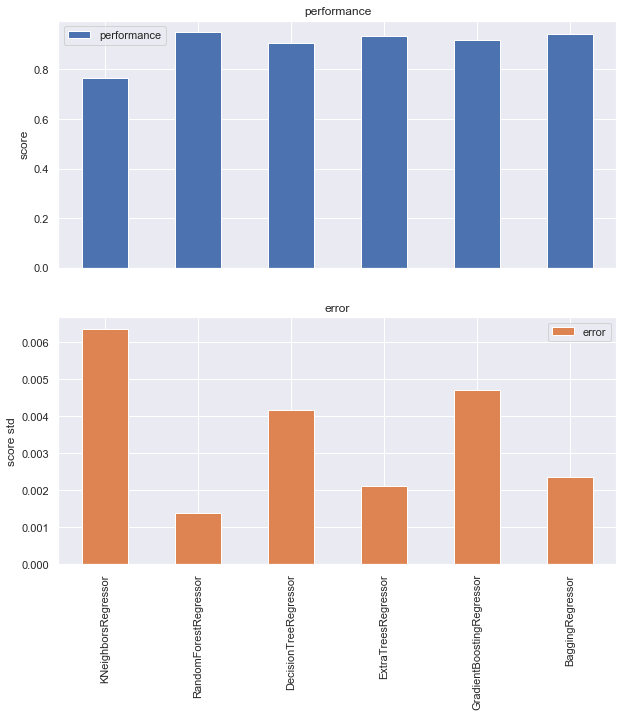

In [30]:
import pandas as pd

dfs=pd.DataFrame({'performance':scores_performance,'error':scores_error},index=modelName)
ax=dfs.plot.bar(subplots=True,figsize=(10,10))
ax[0].set_ylabel("score")
ax[1].set_ylabel("score std")

<div>
    <h1>II) hyper-parameter documentation  </h1>

</div>

After testing 6 models, the best performing model is <b><span style="color:red">RandomForestRegressor</span></b> 
with a score 95% : 

<p><h5>default :</h5>  sklearn.ensemble.RandomForestRegressor(n_estimators=100, criterion='mse', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, ccp_alpha=0.0, max_samples=None)</p>

<h5>the importance of hyper-parameter: </h5>

1. n_estimators: The n_estimators parameter specifies the number of trees in the forest of the model, Usually the higher the number of trees the better to learn the data. However, adding a lot of trees can slow down the training process considerably,   and it will not overfit when increasing the number of trees in the forest

2. max_depth: The max_depth parameter specifies the maximum depth of each tree. The default value for max_depth is None, which means that each tree will expand until every leaf is pure. A pure leaf is one where all of the data on the leaf comes from the same class. and  model overfits for large depth values. The trees perfectly predicts all of the train data, however, it fails to generalize the findings for new data

3. min_samples_split: The min_samples_split parameter specifies the minimum number of samples required to split an internal leaf node. The default value for this parameter is 2, which means that an internal node must have at least two samples before it can be split to have a more specific classification. Increasing this value can cause underfitting

4. min_samples_leaf: The min_samples_leaf parameter specifies the minimum number of samples required to be at a leaf node. The default value for this parameter is 1, which means that every leaf must have at least 1 sample that it classifies.
Increasing this value can cause underfitting

5. max_features: represents the number of features to consider when looking for the best split

<div>
    <h1>III) Best Hyper-parameters  </h1>

</div>

In [58]:
from sklearn.model_selection import GridSearchCV

In [60]:
hyperF = {
    'max_depth': [5, 8, 15, 25, 30],
    'min_samples_leaf': [1, 2, 5, 10] ,
    'min_samples_split': [2, 5, 10, 15, 100],
    'n_estimators': [100, 300,500,800, 1000]
}

forest = RandomForestRegressor()
gridF = GridSearchCV(forest, hyperF, cv = 3, verbose = 1, 
                      n_jobs = -1)

In [61]:
gridF.fit(X_train,Y_train)

Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed: 24.0min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed: 60.5min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed: 123.8min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed: 224.0min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 282.4min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': [5, 8, 15, 25, 30],


In [62]:
gridF.best_params_

{'max_depth': 30,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 1000}

In [73]:
gridF.best_estimator_


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=30,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [28]:
from sklearn.model_selection import RandomizedSearchCV

In [32]:
import numpy as np
hyperF = {
    'max_depth': [int(x) for x in np.linspace(start = 5, stop = 40, num = 5)],
    'min_samples_leaf': [int(x) for x in np.linspace(start = 1, stop = 12, num = 5)] ,
    'min_samples_split': [int(x) for x in np.linspace(start = 2, stop = 100, num = 5)],
    'n_estimators': [int(x) for x in np.linspace(start = 90, stop = 1200, num = 6)]
}  

forest = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = forest, param_distributions = hyperF,
                               n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

In [33]:
rf_random.fit(X_train,Y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/opt/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/opt/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/opt/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  2

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'max_depth': [5, 13, 22, 31, 40], 'min_samples_leaf': [1, 3, 6, 9, 12], 'min_samples_split': [2, 26, 51, 75, 100], 'n_estimators': [90, 312, 534, 756, 978, 1200]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [34]:
rf_random.best_params_

{'n_estimators': 1200,
 'min_samples_split': 2,
 'min_samples_leaf': 3,
 'max_depth': 31}

In [35]:
rf_random.best_estimator_


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=31,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=3, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1200, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [37]:
scores = cross_val_score(rf_random.best_estimator_, X_train, Y_train, cv=5, scoring=make_scorer(scoring_function))

In [38]:
print('\nCV score (95 perc. CI): %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))


CV score (95 perc. CI): 0.95 (+/- 0.00)


<h1><span style="color:red">GradientBoostingRegressor</span></h1>

In [35]:
from sklearn.ensemble import GradientBoostingRegressor
import numpy as np

In [42]:
from sklearn.model_selection import RandomizedSearchCV
hyperF = {
    'max_depth': [int(x) for x in np.linspace(start = 5, stop = 20, num = 4)],
    'min_samples_leaf': [int(x) for x in np.linspace(start = 1, stop = 12, num = 4)] ,
    'min_samples_split': [int(x) for x in np.linspace(start = 2, stop = 50, num = 4)],
    'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 1200, num = 6)]
}  

gradient = GradientBoostingRegressor()
rf_random = RandomizedSearchCV(estimator = gradient, param_distributions = hyperF,
                               n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

In [43]:
rf_random.fit(X_train,Y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 26.9min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed: 133.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 325.7min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=GradientBoostingRegressor(alpha=0.9,
                                                       criterion='friedman_mse',
                                                       init=None,
                                                       learning_rate=0.1,
                                                       loss='ls', max_depth=3,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                            

In [44]:
rf_random.best_params_

{'n_estimators': 600,
 'min_samples_split': 18,
 'min_samples_leaf': 8,
 'max_depth': 10}

In [45]:
rf_random.best_score_

0.9583802641886813

ValueError: x and y must have same first dimension, but have shapes (5,) and (1,)

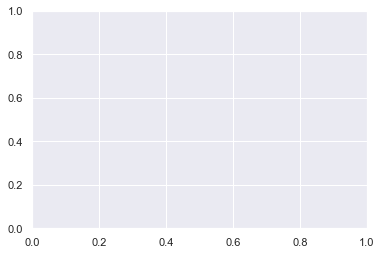

In [53]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
sc=[]
estimators=range(200,1200,200)
for n in estimators:
    scores=cross_val_score(GradientBoostingRegressor(n_estimators=n), X_train, Y_train, cv=5, scoring=make_scorer(scoring_function))
    sc.append(scores.mean())
    


Text(0.5, 1.0, 'GradientBoostingRegressor in function of estimators')

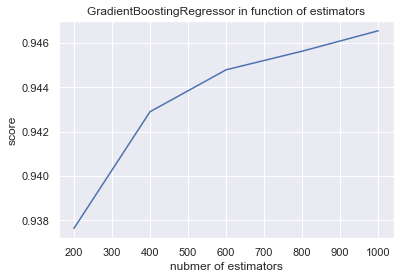

In [54]:
est=np.array(estimators)

plt.plot(estimators,sc)
plt.xlabel('nubmer of estimators')
plt.ylabel('score')
plt.title('GradientBoostingRegressor in function of estimators')

Text(0.5, 1.0, 'GradientBoostingRegressor in function of min_samples_leaf')

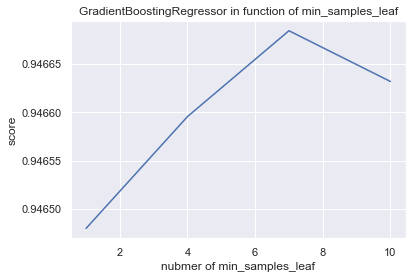

In [65]:
sc=[]
msl=range(1,12,3)

for n in msl:
    scores=cross_val_score(GradientBoostingRegressor(n_estimators=1000,min_samples_leaf=n), X_train, Y_train, cv=5, scoring=make_scorer(scoring_function))
    sc.append(scores.mean())

ms=np.array(msl)
    
plt.plot(ms,sc)
plt.xlabel('nubmer of min_samples_leaf')
plt.ylabel('score')
plt.title('GradientBoostingRegressor in function of min_samples_leaf')

In [24]:
sc=[]
md=range(5,21,5)
for n in md:
    scores=cross_val_score(GradientBoostingRegressor(n_estimators=1000,max_depth=n), X_train, Y_train, cv=5, scoring=make_scorer(scoring_function))
    sc.append(scores.mean())

mdarray=np.array(md)
    
plt.plot(mdarray,sc)
plt.xlabel('nubmer of max_depth')
plt.ylabel('score')
plt.title('GradientBoostingRegressor in function of max_depth')

KeyboardInterrupt: 

In [32]:
sc=[]

mss=range(2,50,10)
for n in mss:
    scores=cross_val_score(GradientBoostingRegressor(n_estimators=1000,min_samples_split=n), X_train, Y_train, cv=5, scoring=make_scorer(scoring_function))
    sc.append(scores.mean())
    


NameError: name 'np' is not defined

Text(0.5, 1.0, 'GradientBoostingRegressor in function of min_samples_split')

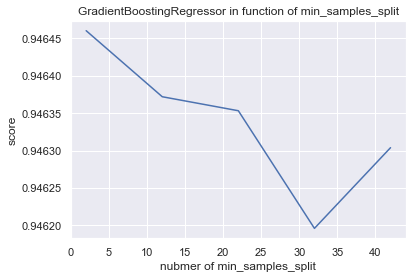

In [33]:
import numpy as np
mssarray=np.array(mss)
plt.plot(mssarray,sc)
plt.xlabel('nubmer of min_samples_split')
plt.ylabel('score')
plt.title('GradientBoostingRegressor in function of min_samples_split')

<h1> Voting </h1>

tried to use StackingRegressor but it woulnd't work even tho i used the python on the university computers 

In [30]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import VotingRegressor
  
mod1=GradientBoostingRegressor(max_depth=10,random_state=0, n_estimators=1000)
mod2=RandomForestRegressor(n_estimators=1200,min_samples_split= 2,min_samples_leaf=3,max_depth= 31)
mod3=DecisionTreeRegressor(max_depth=10,random_state=0)
mod4=ExtraTreesRegressor(max_depth=10,random_state=0, n_estimators=1000)
mod5=BaggingRegressor(random_state=0, n_estimators=1000)

er = VotingRegressor([
                    ('GradientBoostingRegressor', mod1),
                    ('RandomForestRegressor', mod2),
                    ('DecisionTreeRegressor', mod3),
                    ('ExtraTreesRegressor', mod4),
                    ('BaggingRegressor',mod5)])  

scores = cross_val_score(er, X_train, Y_train, cv=5, scoring=make_scorer(scoring_function))
print('\nCV score (95 perc. CI): %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))


CV score (95 perc. CI): 0.95 (+/- 0.00)
